# Etsy Exploratory Data Analysis

This is an exercise in exploring Etsy's stores and trends within the public dataset of Etsy's sellers, notably the European marketplace. </br>
We use a public dataset from Kaggle up to April 2020. Furthermore, this is only a sample of approximately 400k sellers on the Etsy site.</br>
<a href='https://www.kaggle.com/snowwlex/etsy-shops?select=raw_shops.csv'>Link To Kaggle Dataset</a>

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../JB Notebooks/Etsy Shops/raw_shops.csv') #Kaggle Dataset
countries = pd.read_csv('https://raw.githubusercontent.com/dbouquin/IS_608/master/NanosatDB_munging/Countries-Continents.csv') #CSV of countries by continent

## Data Cleaning and Wrangling

First we have to perform various string operations to clean the raw data from the dataset.

In [3]:
df = df[df['seller_location'] != '-']
df.replace('-',np.NaN, inplace=True)
df['seller_join_date'].replace('On Etsy since ','', inplace=True, regex=True)
df['number_of_sales'].replace(' Sales','', inplace=True, regex=True)
df['number_of_sales'].replace(' Sale','', inplace=True, regex=True)
df['number_of_sales'].replace(' on Etsy','', inplace=True, regex=True)
df['number_of_reviews'].replace('\(','', inplace=True, regex=True)
df['number_of_reviews'].replace('\)','', inplace=True, regex=True)

In [4]:
#Drop columns with no data NaN
df.drop(columns=['number_of_admirers','date_of_last_review_left'], inplace=True)

Now we have to split the location into 'Region' and 'Country' according to the location and append to the DataFrame.

In [5]:
location = df['seller_location'].str.split(", ", n=1, expand=True)

In [6]:
df['Region'] = location[0]
df['Country'] = location[1]
df['Country'].replace('None',np.NaN, inplace=True)

In [7]:
df.dtypes

seller_location         object
seller_join_date        object
number_of_sales         object
number_of_reviews       object
average_review_score    object
number_of_items          int64
Region                  object
Country                 object
dtype: object

Now we see that some of the column types are not what we want them to be. Specifically, we need to convert some columns into floats to perform numerical analysis.

In [8]:
df['number_of_reviews'] = pd.to_numeric(df['number_of_reviews'],errors='coerce')
df = df.astype({'seller_join_date':'datetime64','number_of_sales':'float64','number_of_reviews':'float64','average_review_score':'float64'})

df['join_year'] = df['seller_join_date'].dt.year
df.drop(df[df['join_year'] == 1969].index, inplace=True)

In [9]:
#Check to see if types are changed
df.dtypes

seller_location                 object
seller_join_date        datetime64[ns]
number_of_sales                float64
number_of_reviews              float64
average_review_score           float64
number_of_items                  int64
Region                          object
Country                         object
join_year                        int64
dtype: object

Now we want to join the Etsy dataset with the countries by continent dataset to get the 'Continent' column. </br>
We then have to manually assign some countries their continent for those that are malformed.

In [10]:
merged = df.merge(countries, how='left', left_on='Country', right_on='Country')

In [11]:
merged.loc[merged['Country'] == 'United States',['Continent']]= 'North America'
merged.loc[merged['Country'] == 'England',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'Wales',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'Russia',['Continent']]= 'Asia'
merged.loc[merged['Country'] == 'Scotland',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'The Netherlands',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'D.C., United States',['Continent']]= 'North America'
merged.loc[merged['Country'] == 'Northern Ireland',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'Hong Kong',['Continent']]= 'Asia'
merged.loc[merged['Country'] == 'South Korea',['Continent']]= 'Asia'
merged.loc[merged['Country'] == 'Czechia',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'Puerto Rico',['Continent']]= 'North America'
merged.loc[merged['Country'] == 'Taiwan',['Continent']]= 'Asia'
merged.loc[merged['Country'] == 'North Macedonia',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'U.S. Virgin Islands',['Continent']]= 'North America'
merged.loc[merged['Country'] == 'Palestine',['Continent']]= 'Asia'
merged.loc[merged['Country'] == 'Isle of Man',['Continent']]= 'Europe'
merged.loc[merged['Country'] == 'Guam',['Continent']]= 'Asia'

In [12]:
#Combine England + UK and change D.C. to United States
merged.dropna(subset=['Country','Continent'], inplace=True)
merged['Country'].replace('England','United Kingdom', inplace=True, regex=True)
merged['Country'].replace('D.C., United States','United States', inplace=True, regex=True)

In [13]:
merged.head(10)

,seller_location,seller_join_date,number_of_sales,number_of_reviews,average_review_score,number_of_items,Region,Country,join_year,Continent
0,"Jaipur, India",2018-01-01,0.0,NaN,NaN,2,Jaipur,India,2018,Asia
1,"Soorts-Hossegor, France",2017-01-01,14.0,2.0,4.0000,0,Soorts-Hossegor,France,2017,Europe
2,"Arizona, United States",2016-01-01,137.0,18.0,5.0000,15,Arizona,United States,2016,North America
3,"Milton Keynes, England",2019-01-01,0.0,NaN,NaN,3,Milton Keynes,United Kingdom,2019,Europe
4,"New York, United States",2012-01-01,13995.0,2087.0,4.9218,369,New York,United States,2012,North America
5,"Montreal, Canada",2015-01-01,1.0,1.0,0.0000,0,Montreal,Canada,2015,North America
6,"Illinois, United States",2014-01-01,0.0,NaN,NaN,1,Illinois,United States,2014,North America
7,"Oklahoma, United States",2012-01-01,10.0,4.0,5.0000,12,Oklahoma,United States,2012,North America
8,"Ohio, United States",2019-01-01,16.0,3.0,5.0000,84,Ohio,United States,2019,North America
9,"Oregon, United States",2013-01-01,4.0,2.0,0.0000,0,Oregon,United States,2013,North America


## EDA

Now we can begin some analysis on our existing dataset.<br>
Let's first try to find any correlations/behaviors between the features.

In [19]:
merged.describe()

,number_of_sales,number_of_reviews,average_review_score,number_of_items,join_year
count,347565.000000,282412.000000,285520.000000,347565.000000,347565.000000
mean,554.923937,152.452474,2.950435,44.679605,2014.505206
std,3929.896401,1130.184296,2.419221,236.398445,3.227868
min,0.000000,1.000000,0.000000,0.000000,2005.000000
25%,6.000000,3.000000,0.000000,0.000000,2012.000000
50%,29.000000,12.000000,4.904300,6.000000,2015.000000
75%,166.000000,58.000000,5.000000,30.000000,2017.000000
max,539221.000000,184489.000000,5.000000,78611.000000,2019.000000


In [21]:
merged.corr()

,number_of_sales,number_of_reviews,average_review_score,number_of_items,join_year
number_of_sales,1.000000,0.914870,0.104158,0.339275,-0.092043
number_of_reviews,0.914870,1.000000,0.082901,0.275927,-0.098888
average_review_score,0.104158,0.082901,1.000000,0.151934,0.353526
number_of_items,0.339275,0.275927,0.151934,1.000000,-0.018152
join_year,-0.092043,-0.098888,0.353526,-0.018152,1.000000


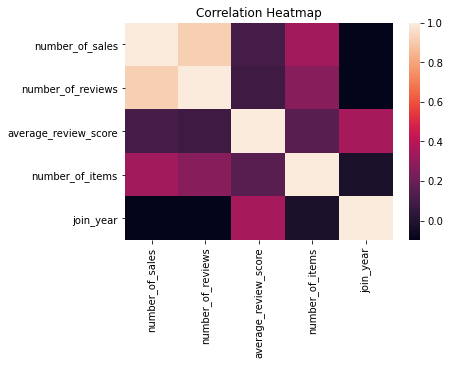

In [22]:
sns.heatmap(merged.corr())
plt.title('Correlation Heatmap')
plt.show()

We see some weak linear relationships between the features. In particular, we have number_of_sales and number_of_reviews being highly correlated.

### Number Of Sellers

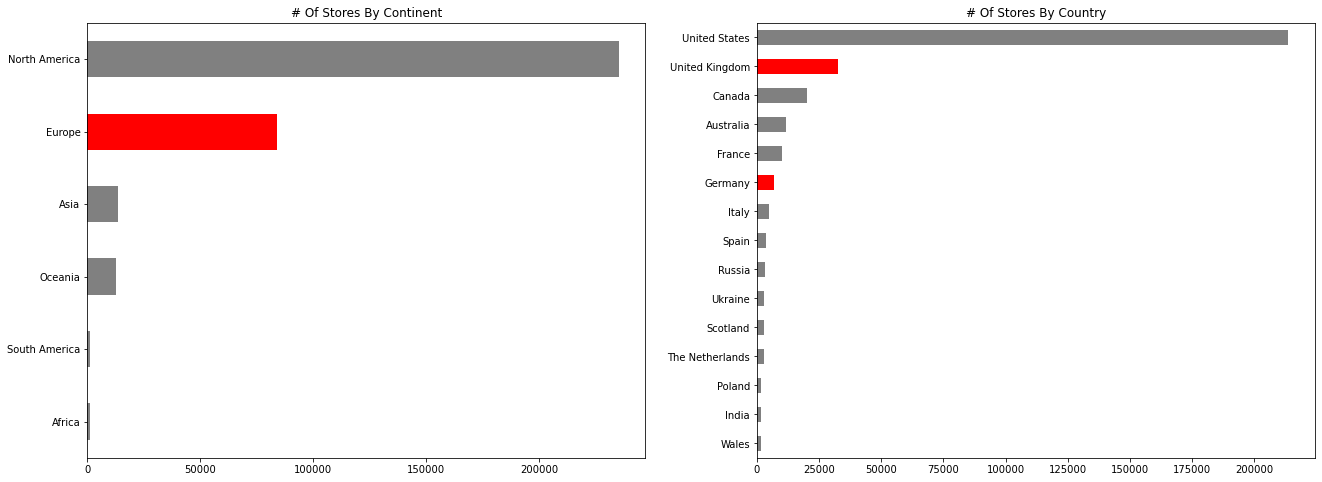

In [14]:
count_df = merged.groupby(by=['Country']).count().sort_values(by='seller_location')
ind = count_df.loc[merged.groupby(by=['Country']).count()['seller_location'] >= 500].index
count_cont_df = merged.groupby(by=['Continent']).count().sort_values(by='seller_location')

plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
ax1 = count_cont_df['seller_location'].sort_values().plot(kind='barh', color = 'gray')
ax1.patches[count_cont_df.tail(15).index.get_loc('Europe')].set_facecolor('r')
plt.title('# Of Stores By Continent')
plt.ylabel(None)

plt.subplot(1,2,2)
ax2 = count_df['seller_location'].tail(15).plot(kind='barh', color='gray')
ax2.patches[count_df.tail(15).index.get_loc('United Kingdom')].set_facecolor('r')
ax2.patches[count_df.tail(15).index.get_loc('Germany')].set_facecolor('r')
plt.title('# Of Stores By Country')
plt.ylabel(None)

plt.show()

We see that Europe is the 2nd biggest continent in terms of number of sellers, but North America as expected comprises of most of the stores on Etsy.<br>
The United Kingdom and Germany make up much of the sellers in Europe.

### Growth Of Etsy Stores In Europe

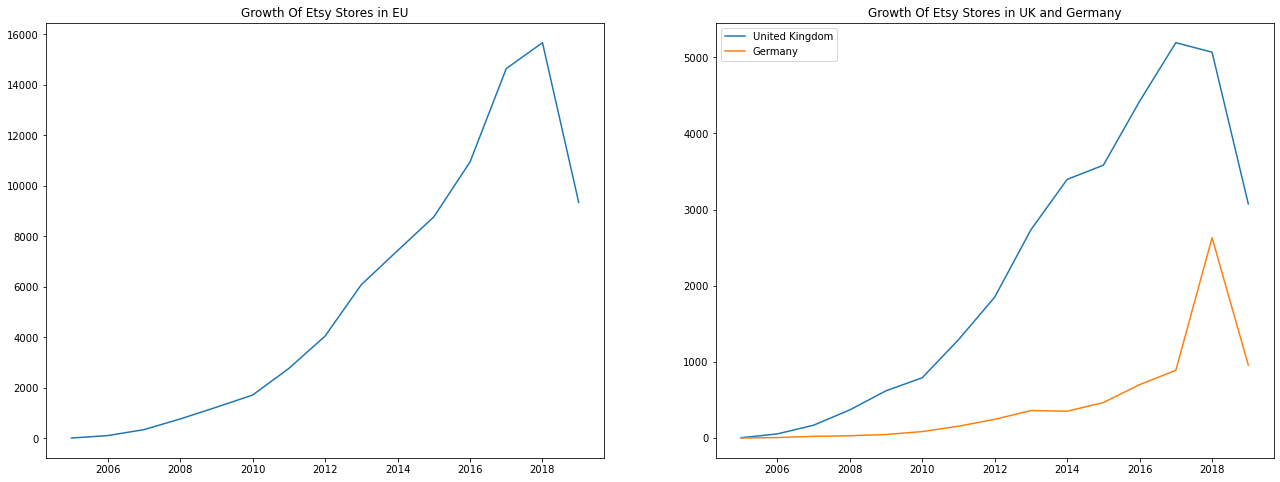

In [15]:
count_uk_df =  merged.groupby(by=['Country','join_year']).count().loc['United Kingdom']
count_ger_df = merged.groupby(by=['Country','join_year']).count().loc['Germany']
count_cont_eu_df = merged.groupby(by=['Continent','join_year']).count().loc['Europe']

plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
ax1 = count_cont_eu_df['seller_location'].plot(kind='line')
plt.title('Growth Of Etsy Stores in EU')
plt.xlabel(None)

plt.subplot(1,2,2)
ax2 = count_uk_df['seller_location'].plot(kind='line')
ax2 = count_ger_df['seller_location'].plot(kind='line')
plt.title('Growth Of Etsy Stores in UK and Germany')
plt.xlabel(None)
plt.legend(['United Kingdom','Germany'])

plt.show()

We see that there is almost an exponential increase in the growth of Etsy in the European market, which is particularly noted in Germany<br>
Note that the number of stores in 2019 may be inaccurate due to the nature of the dataset.

### Sales Numbers

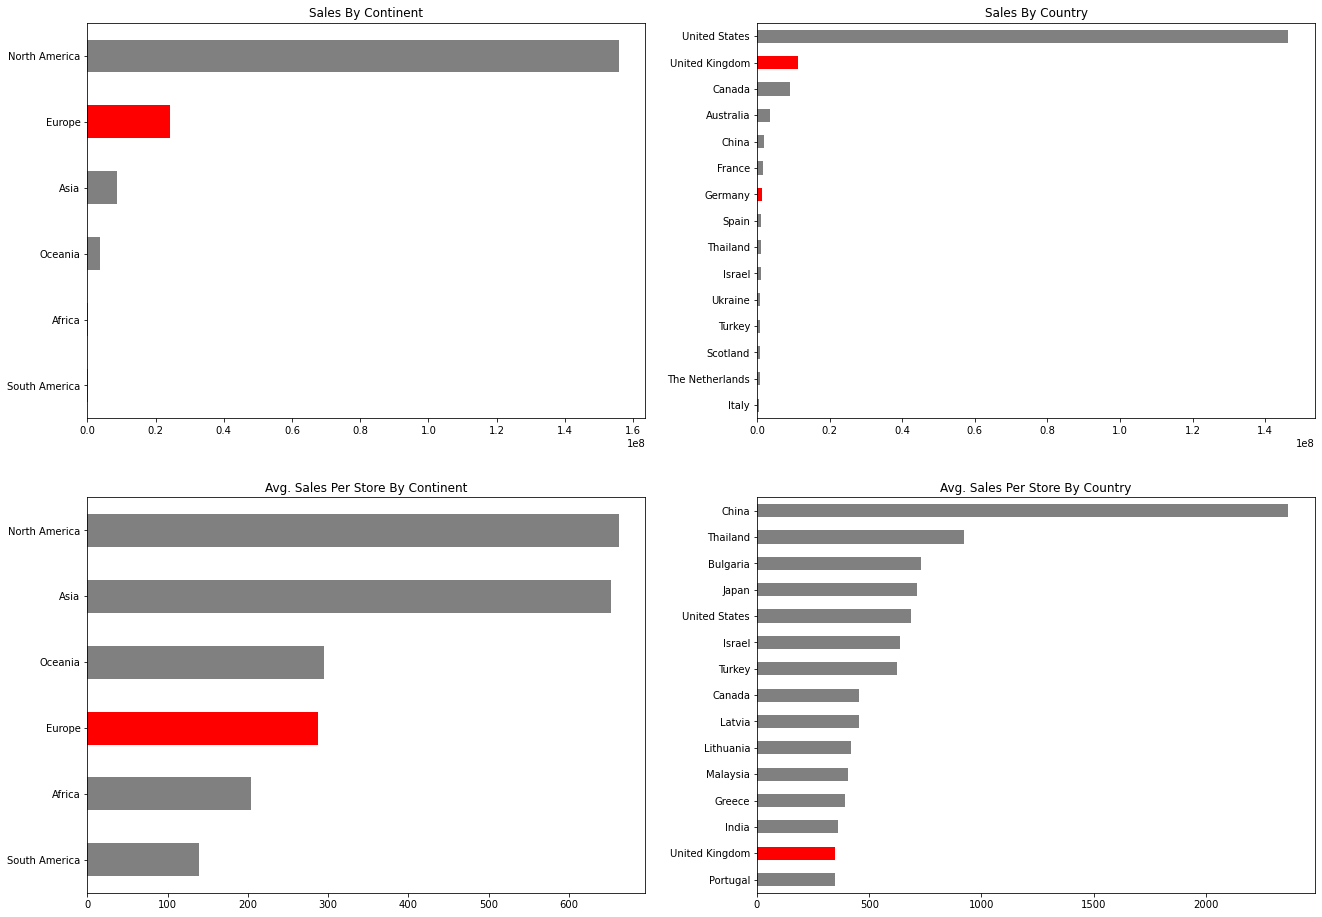

In [16]:
sales_df = merged.groupby(by=['Country'])[['number_of_sales']].sum().loc[ind].sort_values(by='number_of_sales')
sales_cont_df = merged.groupby(by=['Continent'])[['number_of_sales']].sum().sort_values(by='number_of_sales')

avg_sales_df = merged.groupby(by=['Country'])[['number_of_sales']].mean().loc[ind].sort_values(by='number_of_sales')
avg_sales_cont_df = merged.groupby(by=['Continent'])[['number_of_sales']].mean().sort_values(by='number_of_sales')

plt.figure(figsize=(22,16))
plt.subplot(2,2,1)
ax1 = sales_cont_df['number_of_sales'].sort_values().plot(kind='barh', color = 'gray')
ax1.patches[sales_cont_df.tail(15).index.get_loc('Europe')].set_facecolor('r')
plt.title('Sales By Continent')
plt.ylabel(None)

plt.subplot(2,2,2)
ax2 = sales_df['number_of_sales'].tail(15).plot(kind='barh', color='gray')
ax2.patches[sales_df.tail(15).index.get_loc('United Kingdom')].set_facecolor('r')
ax2.patches[sales_df.tail(15).index.get_loc('Germany')].set_facecolor('r')
plt.title('Sales By Country')
plt.ylabel(None)

plt.subplot(2,2,3)
ax3 = avg_sales_cont_df['number_of_sales'].tail(15).plot(kind='barh', color='gray')
ax3.patches[avg_sales_cont_df.tail(15).index.get_loc('Europe')].set_facecolor('r')
plt.title('Avg. Sales Per Store By Continent')
plt.ylabel(None)

plt.subplot(2,2,4)
ax4 = avg_sales_df['number_of_sales'].tail(15).plot(kind='barh', color='gray')
ax4.patches[avg_sales_df.tail(15).index.get_loc('United Kingdom')].set_facecolor('r')
plt.title('Avg. Sales Per Store By Country')
plt.ylabel(None)

plt.show()

We can see again that Europe is the 2nd biggest continent in terms of total sales, with the UK and Germany making up a majority of those sales.<br>
We also see something interesting in Avg. Sales per Store. It seems that North America and Asia have more sales per seller compared to the rest of the world. China by far seems to have the most sales per store.

### Number Of Items

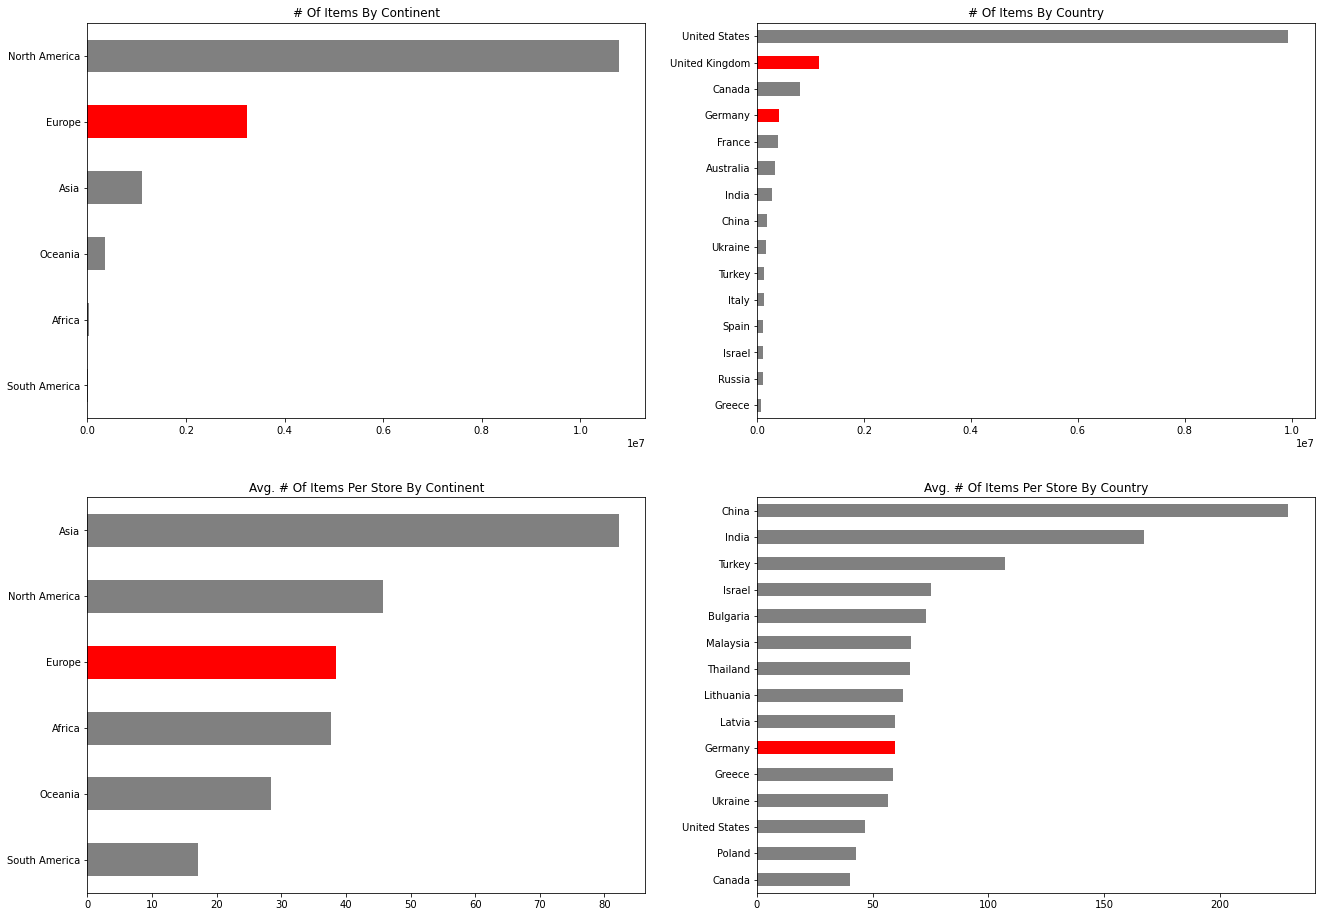

In [17]:
items_df = merged.groupby(by=['Country'])[['number_of_items']].sum().loc[ind].sort_values(by='number_of_items')
items_cont_df = merged.groupby(by=['Continent'])[['number_of_items']].sum().sort_values(by='number_of_items')

avg_items_df = merged.groupby(by=['Country'])[['number_of_items']].mean().loc[ind].sort_values(by='number_of_items')
avg_items_cont_df = merged.groupby(by=['Continent'])[['number_of_items']].mean().sort_values(by='number_of_items')


plt.figure(figsize=(22,16))
plt.subplot(2,2,1)
ax1 = items_cont_df['number_of_items'].plot(kind='barh', color='gray')
ax1.patches[items_cont_df.index.get_loc('Europe')].set_facecolor('r')
plt.title('# Of Items By Continent')
plt.ylabel(None)

plt.subplot(2,2,2)
ax2 = items_df['number_of_items'].tail(15).plot(kind='barh', color='gray')
ax2.patches[items_df.tail(15).index.get_loc('United Kingdom')].set_facecolor('r')
ax2.patches[items_df.tail(15).index.get_loc('Germany')].set_facecolor('r')
plt.title('# Of Items By Country')
plt.ylabel(None)

plt.subplot(2,2,3)
ax3 = avg_items_cont_df['number_of_items'].plot(kind='barh', color='gray')
ax3.patches[avg_items_cont_df.index.get_loc('Europe')].set_facecolor('r')
plt.title('Avg. # Of Items Per Store By Continent')
plt.ylabel(None)

plt.subplot(2,2,4)
ax4 = avg_items_df['number_of_items'].tail(15).plot(kind='barh', color='gray')
ax4.patches[avg_items_df.tail(15).index.get_loc('Germany')].set_facecolor('r')
plt.title('Avg. # Of Items Per Store By Country')
plt.ylabel(None)

plt.show()

Again, we see Europe being the 2nd biggest market in terms of number of items on the marketplace.<br>
For average items per store, it seems that North America has slightly more items per store than Europe. However, China dominates both, suggesting that the sellers in China, while fewer in number, are quite big on Etsy.

### Average Review Score

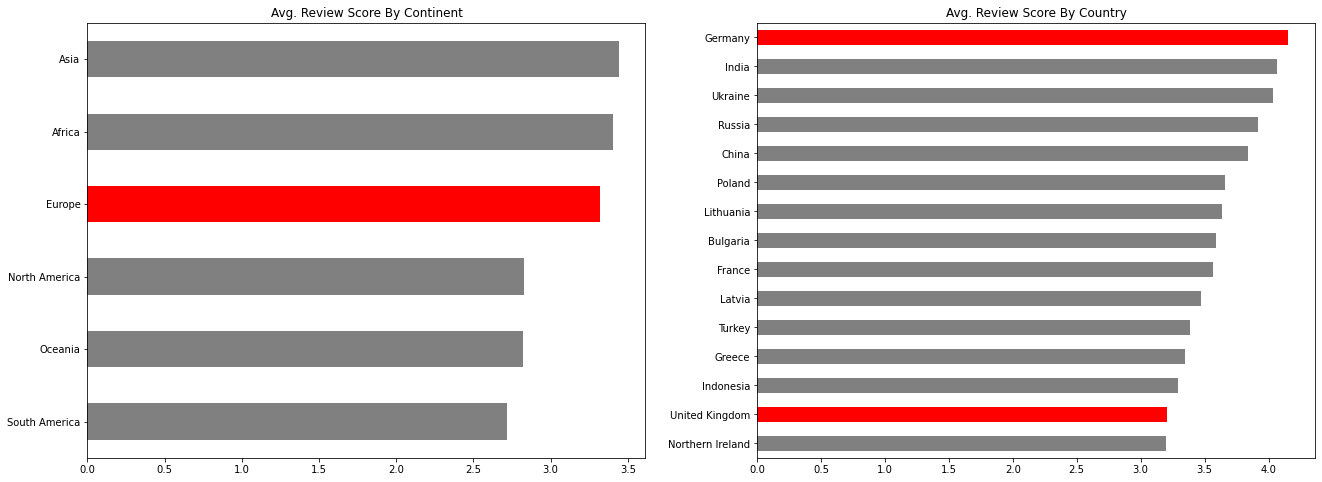

In [18]:
avg_reviews_df = merged.groupby(by=['Country'])[['average_review_score']].mean().loc[ind].sort_values(by='average_review_score')
avg_reviews_cont_df = merged.groupby(by=['Continent'])[['average_review_score']].mean().sort_values(by='average_review_score')

plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
ax1 = avg_reviews_cont_df['average_review_score'].plot(kind='barh', color='gray')
ax1.patches[avg_reviews_cont_df.index.get_loc('Europe')].set_facecolor('r')
plt.title('Avg. Review Score By Continent')
plt.ylabel(None)
plt.subplot(1,2,2)
ax2 = avg_reviews_df['average_review_score'].tail(15).plot(kind='barh', color='gray')
ax2.patches[avg_reviews_df.tail(15).index.get_loc('United Kingdom')].set_facecolor('r')
ax2.patches[avg_reviews_df.tail(15).index.get_loc('Germany')].set_facecolor('r')
plt.title('Avg. Review Score By Country')
plt.ylabel(None)
plt.show()

Looking at the average review scores, we see that Europe is ahead of North America, while being slightly behind Asia and Africa.<br>
From the country breakdown, we have Germany as the top spot in average review score, suggesting users who buy products from Germany are more satisfied with German products.

We can also take a look at the distribution of the average review score in Europe.

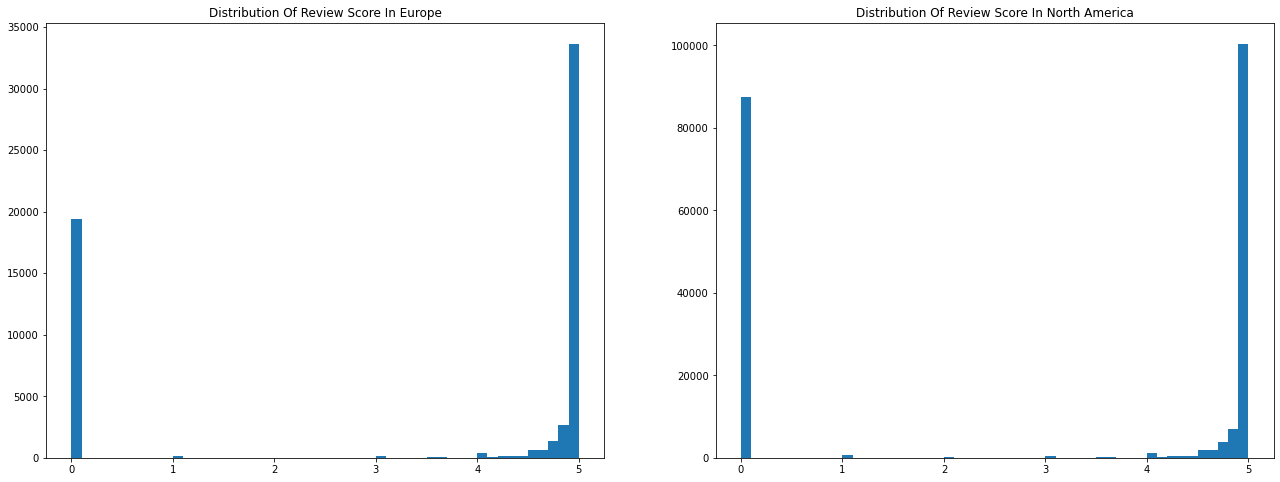

In [62]:
avg_review_score_EU_df = merged.loc[merged['Continent'] == 'Europe','average_review_score']
avg_review_score_EU_df.dropna(inplace=True)

avg_review_score_NA_df = merged.loc[merged['Continent'] == 'North America','average_review_score']
avg_review_score_NA_df.dropna(inplace=True)

plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
ax1 = avg_review_score_EU_df.hist(bins=50)
ax1.grid(False)
plt.title('Distribution Of Review Score In Europe')
plt.subplot(1,2,2)
ax2 = avg_review_score_NA_df.hist(bins=50)
plt.title('Distribution Of Review Score In North America')
ax2.grid(False)
plt.show()

We see that there are proportionally more reviews marked as 0 for North America compared to Europe, which explains the lower overall average review score.